# Depths




In [1]:
import numpy as np
from astropy.table import Table, join
from astropy.io import fits
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
from scipy.interpolate import interp1d

import scipy
from scipy.optimize import curve_fit
import scipy.stats
import pickle
import os
from pymoc.util import catalog
from pymoc import MOC
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
#import utils

from herschelhelp_internal.utils import flux_to_mag, mag_to_flux, inMoc, coords_to_hpidx
from herschelhelp.external import convert_table_for_cigale

### Catalogues from HS-82 and deeper surveys

In [3]:
DMU_DIR = '../dmu_products/'
FIELD = 'Herschel-Stripe-82'
# final_cat = Table.read('../dmu_products/dmu1/dmu1_ml_Herschel-Stripe-82/data/master_catalogue_herschel-stripe-82_20180307.fits', memmap=True)
depths_cat = Table.read('../dmu_products/dmu1/dmu1_ml_Herschel-Stripe-82/data/depths_herschel-stripe-82_20210513.fits', memmap=True)

In [4]:
depths_cat[:5]

hp_idx_O_13,hp_idx_O_10,ferr_ap_suprime_g_mean,f_ap_suprime_g_p90,ferr_suprime_g_mean,f_suprime_g_p90,ferr_ap_suprime_r_mean,f_ap_suprime_r_p90,ferr_suprime_r_mean,f_suprime_r_p90,ferr_ap_suprime_i_mean,f_ap_suprime_i_p90,ferr_suprime_i_mean,f_suprime_i_p90,ferr_ap_suprime_z_mean,f_ap_suprime_z_p90,ferr_suprime_z_mean,f_suprime_z_p90,ferr_ap_suprime_y_mean,f_ap_suprime_y_p90,ferr_suprime_y_mean,f_suprime_y_p90,ferr_ap_suprime_n921_mean,f_ap_suprime_n921_p90,ferr_suprime_n921_mean,f_suprime_n921_p90,ferr_ap_suprime_n816_mean,f_ap_suprime_n816_p90,ferr_suprime_n816_mean,f_suprime_n816_p90,ferr_ap_vista_y_mean,f_ap_vista_y_p90,ferr_vista_y_mean,f_vista_y_p90,ferr_ap_vista_h_mean,f_ap_vista_h_p90,ferr_vista_h_mean,f_vista_h_p90,ferr_ap_wircam_j_mean,f_ap_wircam_j_p90,ferr_wircam_j_mean,f_wircam_j_p90,ferr_ap_vista_j_mean,f_ap_vista_j_p90,ferr_vista_j_mean,f_vista_j_p90,ferr_ap_wircam_ks_mean,f_ap_wircam_ks_p90,ferr_wircam_ks_mean,f_wircam_ks_p90,ferr_ap_vista_ks_mean,f_ap_vista_ks_p90,ferr_vista_ks_mean,f_vista_ks_p90,ferr_ukidss_y_mean,f_ukidss_y_p90,ferr_ap_ukidss_y_mean,f_ap_ukidss_y_p90,ferr_ukidss_j_mean,f_ukidss_j_p90,ferr_ap_ukidss_j_mean,f_ap_ukidss_j_p90,ferr_ap_ukidss_h_mean,f_ap_ukidss_h_p90,ferr_ukidss_h_mean,f_ukidss_h_p90,ferr_ap_ukidss_k_mean,f_ap_ukidss_k_p90,ferr_ukidss_k_mean,f_ukidss_k_p90,ferr_ap_gpc1_g_mean,f_ap_gpc1_g_p90,ferr_gpc1_g_mean,f_gpc1_g_p90,ferr_ap_gpc1_r_mean,f_ap_gpc1_r_p90,ferr_gpc1_r_mean,f_gpc1_r_p90,ferr_ap_gpc1_i_mean,f_ap_gpc1_i_p90,ferr_gpc1_i_mean,f_gpc1_i_p90,ferr_ap_gpc1_z_mean,f_ap_gpc1_z_p90,ferr_gpc1_z_mean,f_gpc1_z_p90,ferr_ap_gpc1_y_mean,f_ap_gpc1_y_p90,ferr_gpc1_y_mean,f_gpc1_y_p90,ferr_ap_irac_i1_mean,f_ap_irac_i1_p90,ferr_irac_i1_mean,f_irac_i1_p90,ferr_ap_irac_i2_mean,f_ap_irac_i2_p90,ferr_irac_i2_mean,f_irac_i2_p90,ferr_ap_decam_i_mean,f_ap_decam_i_p90,ferr_decam_i_mean,f_decam_i_p90,ferr_ap_decam_y_mean,f_ap_decam_y_p90,ferr_decam_y_mean,f_decam_y_p90,ferr_ap_decam_g_mean,f_ap_decam_g_p90,ferr_decam_g_mean,f_decam_g_p90,ferr_ap_decam_r_mean,f_ap_decam_r_p90,ferr_decam_r_mean,f_decam_r_p90,ferr_ap_decam_z_mean,f_ap_decam_z_p90,ferr_decam_z_mean,f_decam_z_p90,ferr_megacam_g_mean,f_megacam_g_p90,ferr_megacam_r_mean,f_megacam_r_p90,ferr_megacam_i_mean,f_megacam_i_p90,ferr_megacam_z_mean,f_megacam_z_p90,ferr_megacam_y_mean,f_megacam_y_p90,ferr_sdss_u_mean,f_sdss_u_p90,ferr_sdss_g_mean,f_sdss_g_p90,ferr_sdss_r_mean,f_sdss_r_p90,ferr_sdss_i_mean,f_sdss_i_p90,ferr_sdss_z_mean,f_sdss_z_p90,ferr_ap_sdss_u_mean,f_ap_sdss_u_p90,ferr_ap_sdss_g_mean,f_ap_sdss_g_p90,ferr_ap_sdss_r_mean,f_ap_sdss_r_p90,ferr_ap_sdss_i_mean,f_ap_sdss_i_p90,ferr_ap_sdss_z_mean,f_ap_sdss_z_p90
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
283010926,4422045,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

## Depths

In [5]:
theta, phi = hp.pixelfunc.pix2ang(hp.order2nside(13),depths_cat['hp_idx_O_13'], nest = True) 
ra,dec = np.degrees(phi), -np.degrees(theta-np.pi/2)

In [6]:
tot_bands = [column[2:-4] for column in depths_cat.colnames 
             if (column.startswith('f_') & ~column.startswith('f_ap_'))]
ap_bands = [column[5:-4] for column in depths_cat.colnames 
            if column.startswith('f_ap_') ]
bands = set(tot_bands) | set(ap_bands)
bands

{'decam_g',
 'decam_i',
 'decam_r',
 'decam_y',
 'decam_z',
 'gpc1_g',
 'gpc1_i',
 'gpc1_r',
 'gpc1_y',
 'gpc1_z',
 'irac_i1',
 'irac_i2',
 'megacam_g',
 'megacam_i',
 'megacam_r',
 'megacam_y',
 'megacam_z',
 'sdss_g',
 'sdss_i',
 'sdss_r',
 'sdss_u',
 'sdss_z',
 'suprime_g',
 'suprime_i',
 'suprime_n816',
 'suprime_n921',
 'suprime_r',
 'suprime_y',
 'suprime_z',
 'ukidss_h',
 'ukidss_j',
 'ukidss_k',
 'ukidss_y',
 'vista_h',
 'vista_j',
 'vista_ks',
 'vista_y',
 'wircam_j',
 'wircam_ks'}

In [7]:
# HELP bands
############

u = [                        'sdss_u']
g = ['suprime_g', 'decam_g', 'sdss_g']
r = ['suprime_r', 'decam_r', 'sdss_r']
i = ['suprime_i', 'decam_i', 'sdss_i']
z = ['suprime_z', 'decam_z', 'sdss_z']
y = ['suprime_y', 'decam_y']

y_nir = ['vista_y',  'ukidss_y']
h = ['vista_h',  'ukidss_h']
j = ['vista_j',  'ukidss_j']
k = ['vista_ks', 'ukidss_k']

helpbands = u + g + r + i + z + y + y_nir + h + j + k
helpbands

['sdss_u',
 'suprime_g',
 'decam_g',
 'sdss_g',
 'suprime_r',
 'decam_r',
 'sdss_r',
 'suprime_i',
 'decam_i',
 'sdss_i',
 'suprime_z',
 'decam_z',
 'sdss_z',
 'suprime_y',
 'decam_y',
 'vista_y',
 'ukidss_y',
 'vista_h',
 'ukidss_h',
 'vista_j',
 'ukidss_j',
 'vista_ks',
 'ukidss_k']

### Test_ area pixels above certain S/N 



In [8]:
def get_moc_above_sn(depths_cat, bands, order, mag, sn):
    """
    parameters:
    ----------------
    band: str
        Band name in depth_catalogue  
    order: int
        healpix order
    mag: float
        Magnitude cut
    sn: int
        Signal to noise
    
    return:
    ----------------
    mocs: list 
        MOCs for each band. Healpix where a source with magnitude "mag" can be detected with s/n >= "sn"
    """
            
    # Convert mag to flux
    f = mag_to_flux(mag) # Flux in Jy
    
    # Maximum noise a healpix cell could have, to detect a source above the given sn
    N = f[0] * 1e6 / sn # in microJy
    
    mocs = []
    for idx, band in enumerate(bands):
        print(band)
        moc_b = MOC()
        ind = depths_cat[band] < N[idx]
        moc_b.add(order, depths_cat['hp_idx_O_{}'.format(order)][ind])
        mocs.append(moc_b)
        
        moc_b.write('./data/mocs/' + band[5:-5] + '_sn' + str(sn) + '_mag_'+ str(mag[idx]) + '.fits', overwrite=True)

    return mocs


### SDSS

In [9]:
sdss_bands = ['ferr_sdss_u_mean',
 'ferr_sdss_g_mean',
 'ferr_sdss_r_mean',
 'ferr_sdss_i_mean',
 'ferr_sdss_z_mean']

In [10]:
magcuts_sdss = {'u': 22.8,
 'g': 23.7,
 'r': 23.5,
 'i': 22.9,
 'z': 21.5}

In [11]:
magcuts_sdss = np.array(list(magcuts_sdss.values()))

In [13]:
mocs_sdss = get_moc_above_sn(depths_cat, sdss_bands, 13, magcuts_sdss, 3)

### HSC

In [12]:
hsc_bands = ['ferr_suprime_g_mean',
 'ferr_suprime_r_mean',
 'ferr_suprime_i_mean',
 'ferr_suprime_z_mean', 
 'ferr_suprime_y_mean']

In [13]:
magcuts_hsc = {
    'g': 25.4,
    'r': 25.4, 
    'i': 25.1,
    'z': 24.2,
    'y': 23.7}

In [14]:
magcuts_hsc = np.array(list(magcuts_hsc.values()))

In [15]:
mocs_hsc = get_moc_above_sn(depths_cat, hsc_bands, 13, magcuts_hsc, 3)

ferr_suprime_g_mean
ferr_suprime_r_mean
ferr_suprime_i_mean
ferr_suprime_z_mean
ferr_suprime_y_mean


### DECam

In [8]:
decals_MOC=MOC()
decals_MOC.read('../dmu_products/dmu1/dmu1_ml_Herschel-Stripe-82/data_tmp/Sub_DECaLS_DES-DR1_Herschel-Stripe-82_MOC.fits')

des_MOC=MOC()
des_MOC.read('../dmu_products/dmu0/dmu0_DES/data/DES-DR1_Herschel-Stripe-82_MOC.fits')

In [9]:
depths_cat_des = depths_cat[inMoc(ra, dec, des_MOC)]

In [10]:
depths_cat_decals = depths_cat[inMoc(ra, dec, decals_MOC)]

In [30]:
des_bands = ['ferr_decam_g_mean',
 'ferr_decam_r_mean',
 'ferr_decam_i_mean',
 'ferr_decam_z_mean', 
 'ferr_decam_y_mean']

In [31]:
magcuts_des = {'g': 23.3,
 'r': 23.1,
 'i': 22.7,
 'z': 21.8,
 'y': 20.6}

In [13]:
magcuts_des = np.array(list(magcuts_des.values()))

In [14]:
mocs_des = get_moc_above_sn(depths_cat_des, des_bands, 13, magcuts_des, 5)

ferr_decam_z_mean
ferr_decam_y_mean


In [15]:
decals_bands = ['ferr_decam_g_mean',
 'ferr_decam_r_mean',
 'ferr_decam_z_mean']

In [16]:
magcuts_decals =  {'g': 23.95, 'r': 23.54, 'z': 22.5}

In [17]:
magcuts_decals = np.array(list(magcuts_decals.values()))

In [18]:
mocs_decals = get_moc_above_sn(depths_cat, decals_bands, 13, magcuts_decals, 5)

ferr_decam_g_mean
ferr_decam_r_mean
ferr_decam_z_mean


In [17]:

nb_band = {}
nb_band['help_id'] = depths_cat['hp_idx_O_13']

nb_band

{'help_id': <MaskedColumn name='hp_idx_O_13' dtype='int64' length=7090628>
 283010926
 283010937
 283010939
 283010938
 283010943
 283010942
 283010927
 283011007
 283011004
 283010972
 283010974
 283010993
       ...
 320214034
 320214016
 320214052
 320214050
 320214144
 320214145
 320214146
 320214147
 320214152
 320214153
 320214154
 320214176}

In [18]:

nb = ['optband', 'nirband', 'mirband']
nx = ['optvalue', 'nirvalue', 'mirvalue']

In [19]:
nb_band[nb[0]] = np.zeros(len(depths_cat))

### VISTA

In [9]:
vhs_MOC=MOC()
vhs_MOC.read('../dmu_products/dmu0/dmu0_VISTA-VHS/data/VHS_Herschel-Stripe-82_MOC.fits')

vics_MOC=MOC()
vics_MOC.read('../dmu_products/dmu1/dmu1_ml_Herschel-Stripe-82/data_tmp/VICS82_VISTA_MOC.fits')

In [ ]:
depths_cat_vhs = depths_cat[inMoc(ra, dec, vhs_MOC)]

In [10]:
depths_cat_vics = depths_cat[inMoc(ra, dec, vics_MOC)]

In [14]:
vista_vhs_bands = ['ferr_vista_y_mean',
 'ferr_vista_h_mean',
 'ferr_vista_j_mean',
 'ferr_vista_ks_mean']

In [15]:
# vhs - s/n > 3
magcuts_vhs = {'y': 20.1,
 'h': 19.6,
 'j': 19.95,
 'k': 19.6}

In [16]:
magcuts_vhs = np.array(list(magcuts_vhs.values()))

In [17]:
mocs_vista_vhs = get_moc_above_sn(depths_cat_vhs, vista_vhs_bands, 13, magcuts_vhs, 3)

ferr_vista_y_mean
ferr_vista_h_mean
ferr_vista_j_mean
ferr_vista_ks_mean


In [11]:
vista_vics_bands = ['ferr_vista_j_mean',
 'ferr_vista_ks_mean']

In [12]:
# vics - s/n > 5
magcuts_vics = {'j': 21.0,
 'k': 21.0}

In [13]:
magcuts_vics = np.array(list(magcuts_vics.values()))

In [15]:
mocs_vista_vics = get_moc_above_sn(depths_cat_vics, vista_vics_bands, 13, magcuts_vics, 5)

ferr_vista_j_mean
ferr_vista_ks_mean


In [18]:
            
    # Convert mag to flux
f = mag_to_flux(magcuts_vics) # Flux in Jy
f

(array([1.44543977e-05, 1.44543977e-05]), None)

In [21]:
# Maximum noise a healpix cell could have, to detect a source above the given sn
sn = 5
N = f[0] * 1e6 / 5 # in microJy
N

array([4.81813257, 4.81813257])

In [ ]:
mocs = []
for idx, band in enumerate(bands):
    print(band)
    moc_b = MOC()
    ind = depths_cat[band] < N[idx]
    moc_b.add(order, depths_cat['hp_idx_O_{}'.format(order)][ind])
    mocs.append(moc_b)

In [ ]:
ind = depths_cat['ferr_vista_ks_mean']

### UKIDSS - LAS

In [20]:
ukidss_bands = ['ferr_ukidss_h_mean',
 'ferr_ukidss_j_mean',
 'ferr_ukidss_k_mean',
 'ferr_ukidss_y_mean']

In [21]:
magcuts_ukidss = {'h':19.0, 'j':19.0, 'k':19.0, 'y':20.16}

In [22]:
magcuts_ukidss = np.array(list(magcuts_ukidss.values()))

In [23]:
mocs_ukidss = get_moc_above_sn(depths_cat, ukidss_bands, 13, magcuts_ukidss, 3)

ferr_ukidss_h_mean
ferr_ukidss_j_mean
ferr_ukidss_k_mean
ferr_ukidss_y_mean


In [42]:
# SDSS
magcuts_sdss = {'sdss_u': 22.8,
 'sdss_g': 23.7,
 'sdss_r': 23.5,
 'sdss_i': 22.9,
 'sdss_z': 21.5}

# HSC
magcuts_hsc = {
    'suprime_g': 25.4,
    'suprime_r': 25.4, 
    'suprime_i': 25.1,
    'suprime_z': 24.2,
    'suprime_y': 23.7}

# DECam: DECaLS + DES
magcuts_des = {'decam_g_des': 23.3,
 'decam_r_des': 23.1,
 'decam_i_des': 22.7,
 'decam_z_des': 21.8,
 'decam_y_des': 20.6}

magcuts_decals =  {'decam_g_decals': 23.9, 'decam_r_decals': 23.5, 'decam_z_decals': 22.5}

# VISTA: VHS + VICS82
magcuts_vhs = {'vista_y_vhs': 20.1,
 'vista_h_vhs': 19.6,
 'vista_j_vhs': 19.9,
 'vista_ks_vhs': 19.6}

magcuts_vics = {'vista_j_vics': 21.0,
 'vista_ks_vics': 21.0}

# UKIDSS - LAS
magcuts_ukidss = {'ukidss_h':19.0, 'ukidss_j':19.0, 'ukidss_k':19.0, 'ukidss_y':20.2}

In [43]:
mcuts = magcuts_sdss.copy()

mcuts.update(magcuts_hsc)
mcuts.update(magcuts_des)
mcuts.update(magcuts_decals)
mcuts.update(magcuts_vhs)
mcuts.update(magcuts_vics)
mcuts.update(magcuts_ukidss)
mcuts

{'sdss_u': 22.8,
 'sdss_g': 23.7,
 'sdss_r': 23.5,
 'sdss_i': 22.9,
 'sdss_z': 21.5,
 'suprime_g': 25.4,
 'suprime_r': 25.4,
 'suprime_i': 25.1,
 'suprime_z': 24.2,
 'suprime_y': 23.7,
 'decam_g_des': 23.3,
 'decam_r_des': 23.1,
 'decam_i_des': 22.7,
 'decam_z_des': 21.8,
 'decam_y_des': 20.6,
 'decam_g_decals': 23.9,
 'decam_r_decals': 23.5,
 'decam_z_decals': 22.5,
 'vista_y_vhs': 20.1,
 'vista_h_vhs': 19.6,
 'vista_j_vhs': 19.9,
 'vista_ks_vhs': 19.6,
 'vista_j_vics': 21.0,
 'vista_ks_vics': 21.0,
 'ukidss_h': 19.0,
 'ukidss_j': 19.0,
 'ukidss_k': 19.0,
 'ukidss_y': 20.2}

In [65]:
def get_area_sn(band, order, sn, mag_limits=[20,28]):
    x = np.linspace(mag_limits[0],mag_limits[1],100)
    x_f = mag_to_flux(x)
    N = x_f[0] * 1e6 / sn

    areas = []
    for idx, n in enumerate(N):
        ind = depths_cat[band] < n

        t_moc = MOC(order, [depths_cat['hp_idx_O_{}'.format(order)][0]])
        area = len(np.unique(depths_cat['hp_idx_O_{}'.format(order)][ind]))*t_moc.area_sq_deg
        areas.append(area)

    areas = np.array(areas)
    
    return areas


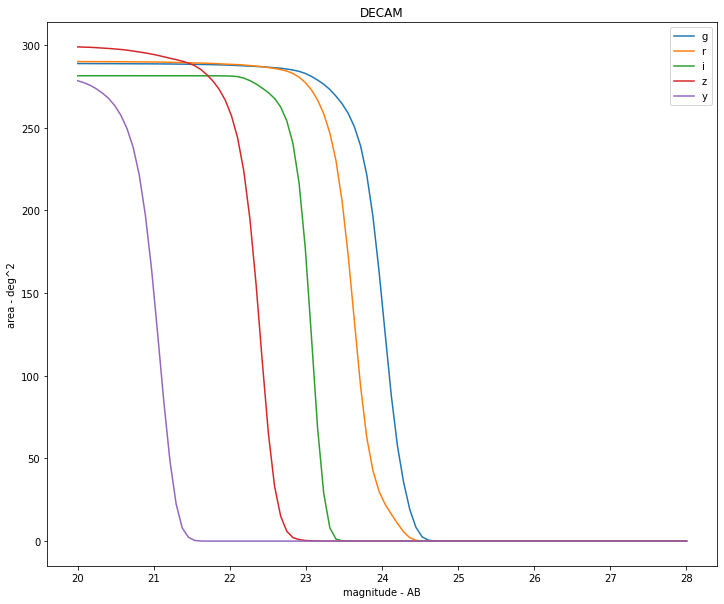

In [8]:
areas_g = get_area_sn('ferr_decam_g_mean', 13, 5)
areas_r = get_area_sn('ferr_decam_r_mean', 13, 5)
areas_i = get_area_sn('ferr_decam_i_mean', 13, 5)
areas_z = get_area_sn('ferr_decam_z_mean', 13, 5)
areas_y = get_area_sn('ferr_decam_y_mean', 13, 5)

areas_decam = [areas_g, areas_r, areas_i, areas_z, areas_y]
areas_lb = ['g', 'r', 'i', 'z', 'y']

x = np.linspace(20,28,100)
plt.figure(figsize=(12,10))
for idx, area in enumerate(areas_decam):
    plt.plot(x, area, label=areas_lb[idx]);

plt.title('DECAM')
plt.xlabel('magnitude - AB')
plt.ylabel('area - deg^2')
plt.legend()